In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
imgs=28
imgpx=imgs*imgs

In [2]:
train=np.loadtxt("data/mnist_train.csv",delimiter=",")
test=np.loadtxt("data/mnist_test.csv",delimiter=",")

In [3]:
div=255*0.99+0.01
train_img=np.asfarray(train[:,1:])/div
test_img=np.asfarray(test[:,1:])/div
test_lab=np.asfarray(test[:,:1])
train_lab=np.asfarray(train[:,:1])

In [4]:
lr=np.arange(10)
for lab in range(10):
    one_hot=(lr==lab).astype(np.int)
    print("label:{} in one-hot {}".format(lab,one_hot))

label:0 in one-hot [1 0 0 0 0 0 0 0 0 0]
label:1 in one-hot [0 1 0 0 0 0 0 0 0 0]
label:2 in one-hot [0 0 1 0 0 0 0 0 0 0]
label:3 in one-hot [0 0 0 1 0 0 0 0 0 0]
label:4 in one-hot [0 0 0 0 1 0 0 0 0 0]
label:5 in one-hot [0 0 0 0 0 1 0 0 0 0]
label:6 in one-hot [0 0 0 0 0 0 1 0 0 0]
label:7 in one-hot [0 0 0 0 0 0 0 1 0 0]
label:8 in one-hot [0 0 0 0 0 0 0 0 1 0]
label:9 in one-hot [0 0 0 0 0 0 0 0 0 1]


In [5]:
lr=np.arange(10)
train_onh=(lr==train_lab).astype(np.float)
test_onh=(lr==test_lab).astype(np.float)
train_onh[train_onh==0]=0.01
test_onh[test_onh==0]=0.01
train_onh[train_onh==1]=0.99
test_onh[test_onh==1]=0.99

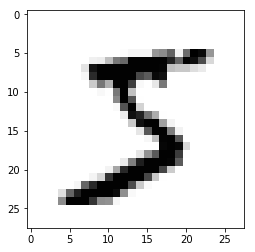

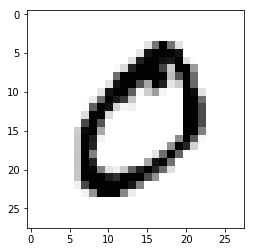

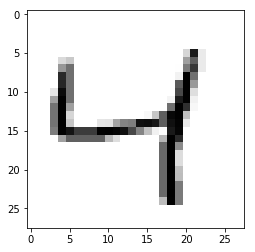

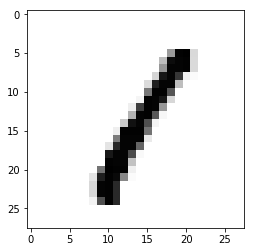

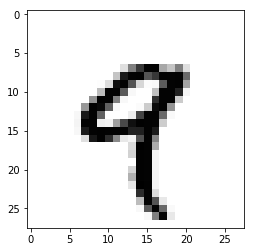

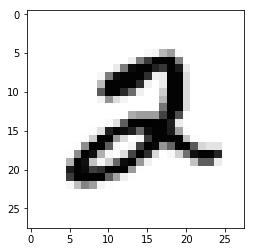

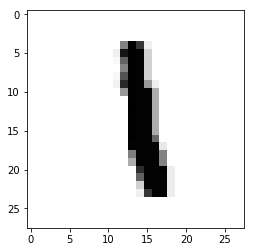

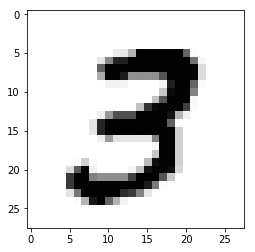

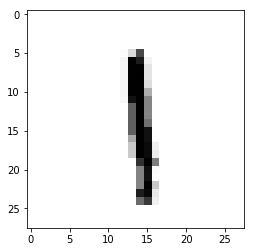

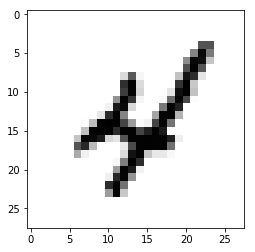

In [6]:
for i in range(0,10):
    img=train_img[i].reshape((28,28))
    plt.imshow(img,cmap="Greys")
    plt.show()

In [12]:
import pickle
path="/root/Downloads/"
with open(path+"mnist.pkl","wb") as fh:
    data=(train_img, test_img, train_lab,test_lab,train_onh,test_onh)
    pickle.dump(data, fh)

In [2]:
import pickle
path="/root/Downloads/"
with open(path+"mnist.pkl", "rb") as fh:
    data = pickle.load(fh)
train_imgs = data[0]
test_imgs = data[1]
train_labels = data[2]
test_labels = data[3]
train_labels_one_hot = data[4]
test_labels_one_hot = data[5]
image_size = 28 
no_of_different_labels = 10
image_pixels = image_size * image_size

In [34]:
import numpy as np
@np.vectorize
def sigmoid(x):
    return 1 / (1 + np.e ** -x)
activ_func=sigmoid
from scipy.stats import truncnorm
from sklearn import metrics
def truncated_normal(mu=0,sd=1,l=0,h=10):
    return truncnorm((l-mu)/sd,(h-mu)/sd,loc=mu,scale=sd)

In [15]:
def reLU(x):
    for i in range(0,len(x)):
        if x[i]<=0.01:
            x[i]=0.01
        else:
            x[i]=0.99
    return x  
activ_func=reLU

In [94]:
class NeuralNetwork:
    def __init__(self,noin,noon,nohdl,lr,bias=None):
        self.noin=noin
        self.noon=noon
        self.nohdl=nohdl
        self.lr=lr
        self.bias=bias
        self.gen_weights()
    def gen_weights(self):
        bias_n=1 if self.bias else 0
        n=1/np.sqrt(self.noin+bias_n)
        X=truncated_normal(mu=0,sd=1,l=-n,h=n)
        self.wih=X.rvs((self.nohdl,self.noin+bias_n))
        n=1/np.sqrt(self.noon+bias_n)
        X=truncated_normal(mu=0,sd=1,l=-n,h=n)
        self.who=X.rvs((self.noon,self.nohdl+bias_n))
    def train(self,inp_vec,tar_vec):
        bias_n=1 if self.bias else 0
        if self.bias:
            inp_vec=np.concatenate((inp_vec,[self.bias]))
        inp_vec=np.array(inp_vec,ndmin=2).T
        tar_vec=np.array(tar_vec,ndmin=2).T
        out_1=np.dot(self.wih,inp_vec)
        out_h=activ_func(out_1)
        if self.bias:
            out_h=np.concatenate((out_h,[[self.bias]]))
        out_2=np.dot(self.who,out_h)
        out_n=activ_func(out_2)
        out_e=tar_vec-out_n
        tmp=out_e*out_n*(1-out_n)
        tmp=self.lr*np.dot(tmp,out_h.T)
        self.who+=tmp
        hid_e=np.dot(self.who.T,out_e)
        tmp=hid_e*out_h*(1-out_h)
        if self.bias:
            x=np.dot(tmp, inp_vec.T)[:-1,:]     
        else:
            x=np.dot(tmp, inp_vec.T)
        self.wih += self.lr * x
    def run(self,inp_vec):
        if self.bias:
            inp_vec = np.concatenate((inp_vec, [1]) )
        inp_vec = np.array(inp_vec, ndmin=2).T
        out_vec = np.dot(self.wih, inp_vec)
        out_vec = activ_func(out_vec)
        if self.bias:
            out_vec= np.concatenate( (out_vec, [[1]]) )
        out_vec = np.dot(self.who, out_vec)
        out_vec = activ_func(out_vec)
        return out_vec
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs
    def confusion_matrix(self, data, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm
    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()
    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()

In [35]:
ANNN = NeuralNetwork(noin=image_pixels, noon=10, nohdl=200,lr=0.1)
t0=time()
for i in range(0,5):
    for i in range(len(train_imgs)):
        ANNN.train(train_imgs[i], train_labels_one_hot[i])
tn=time()-t0
print("MODEL TOOK {} SECONDS".format(tn))

MODEL TOOK 299.362188816 SECONDS


In [36]:
apred1=[]
for i in range(len(test_imgs)):
    res = ANNN.run(test_imgs[i])
    res_max = res.argmax()
    apred1.append(res_max)

In [40]:
metrics.accuracy_score(apred1,test_labels)

0.9704

In [41]:
apred=[]
def confusion_matrix(data, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data)):
            res = ANNN.run(data[i])
            res_max = res.argmax()
            apred.append(res_max)
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm
confusion_matrix(test_imgs,test_labels)

array([[ 973,    0,    7,    1,    2,    5,   12,    1,    7,    7],
       [   0, 1121,    1,    0,    0,    1,    3,    7,    3,    4],
       [   1,    3,  999,    1,    0,    0,    1,    9,    2,    0],
       [   1,    1,    8,  986,    0,   14,    1,    2,    8,    6],
       [   0,    0,    2,    0,  950,    0,    2,    1,    3,    7],
       [   1,    1,    0,    8,    0,  864,   15,    1,   10,    2],
       [   2,    3,    1,    0,    5,    3,  921,    0,    4,    0],
       [   1,    1,    8,    5,    1,    1,    0,  992,    5,    3],
       [   1,    5,    5,    2,    1,    3,    3,    2,  919,    1],
       [   0,    0,    1,    7,   23,    1,    0,   13,   13,  979]])

In [42]:
metrics.accuracy_score(apred1,test_labels)*100

97.04

In [43]:
cm=confusion_matrix(test_imgs,test_labels)
cm

array([[ 973,    0,    7,    1,    2,    5,   12,    1,    7,    7],
       [   0, 1121,    1,    0,    0,    1,    3,    7,    3,    4],
       [   1,    3,  999,    1,    0,    0,    1,    9,    2,    0],
       [   1,    1,    8,  986,    0,   14,    1,    2,    8,    6],
       [   0,    0,    2,    0,  950,    0,    2,    1,    3,    7],
       [   1,    1,    0,    8,    0,  864,   15,    1,   10,    2],
       [   2,    3,    1,    0,    5,    3,  921,    0,    4,    0],
       [   1,    1,    8,    5,    1,    1,    0,  992,    5,    3],
       [   1,    5,    5,    2,    1,    3,    3,    2,  919,    1],
       [   0,    0,    1,    7,   23,    1,    0,   13,   13,  979]])

In [45]:
metrics.confusion_matrix(apred1,test_labels)

array([[ 973,    0,    7,    1,    2,    5,   12,    1,    7,    7],
       [   0, 1121,    1,    0,    0,    1,    3,    7,    3,    4],
       [   1,    3,  999,    1,    0,    0,    1,    9,    2,    0],
       [   1,    1,    8,  986,    0,   14,    1,    2,    8,    6],
       [   0,    0,    2,    0,  950,    0,    2,    1,    3,    7],
       [   1,    1,    0,    8,    0,  864,   15,    1,   10,    2],
       [   2,    3,    1,    0,    5,    3,  921,    0,    4,    0],
       [   1,    1,    8,    5,    1,    1,    0,  992,    5,    3],
       [   1,    5,    5,    2,    1,    3,    3,    2,  919,    1],
       [   0,    0,    1,    7,   23,    1,    0,   13,   13,  979]])

In [44]:
import pandas as pd
cmf=pd.DataFrame(cm)
cmf.rename_axis("predicted",axis=1,inplace=True)
cmf.rename_axis("observed",axis=0,inplace=True)
cmf

predicted,0,1,2,3,4,5,6,7,8,9
observed,,,,,,,,,,
0,973,0,7,1,2,5,12,1,7,7
1,0,1121,1,0,0,1,3,7,3,4
2,1,3,999,1,0,0,1,9,2,0
3,1,1,8,986,0,14,1,2,8,6
4,0,0,2,0,950,0,2,1,3,7
5,1,1,0,8,0,864,15,1,10,2
6,2,3,1,0,5,3,921,0,4,0
7,1,1,8,5,1,1,0,992,5,3
8,1,5,5,2,1,3,3,2,919,1


In [46]:
def precision(label, cm):
    col=cm.iloc[label,label]
    den=cm.iloc[:,label]
    return float(col)/(den.sum())
def recall(label, cm):
    row = cm.iloc[label]
    return cm.iloc[label, label]/float(row.sum())

In [47]:
print("precision for 0-9 in artificial neural network")
for i in range(10):
    print(i,precision(i,cmf))

precision for 0-9 in artificial neural network
(0, 0.9928571428571429)
(1, 0.9876651982378855)
(2, 0.9680232558139535)
(3, 0.9762376237623762)
(4, 0.9674134419551935)
(5, 0.968609865470852)
(6, 0.9613778705636743)
(7, 0.9649805447470817)
(8, 0.9435318275154004)
(9, 0.9702675916749257)


In [49]:
precisionn=metrics.precision_score(apred1,test_labels,average=None)
precisionn

array([0.99285714, 0.9876652 , 0.96802326, 0.97623762, 0.96741344,
       0.96860987, 0.96137787, 0.96498054, 0.94353183, 0.97026759])

In [50]:
recal=metrics.recall_score(apred1,test_labels,average=None)
recal

array([0.95862069, 0.98333333, 0.98326772, 0.9600779 , 0.98445596,
       0.9578714 , 0.98083067, 0.9754179 , 0.97558386, 0.94406943])

In [51]:
print("recall for 0-9  in artificial neural network")
for i in range(10):
    print(i,recall(i,cmf))

recall for 0-9  in artificial neural network
(0, 0.9586206896551724)
(1, 0.9833333333333333)
(2, 0.9832677165354331)
(3, 0.9600778967867576)
(4, 0.9844559585492227)
(5, 0.9578713968957872)
(6, 0.9808306709265175)
(7, 0.9754178957718781)
(8, 0.975583864118896)
(9, 0.944069431051109)
